# Ajit Samudrala

In [1]:
import os
import re
from io import StringIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import xgboost as xgb
%matplotlib inline

from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn import preprocessing, decomposition, model_selection, metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.decomposition import KernelPCA, PCA
from keras.layers import GlobalAvgPool1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D, AveragePooling1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from keras import backend as K
import nltk
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [2]:
base_dir_train = '/Users/ajit_samudrala/author_attribution/train'
base_dir_test = '/Users/ajit_samudrala/author_attribution/test'

In [3]:
def read_files(base_dir):
    """
    This function reads files from the given base directory and returns a Dataframe with two columns, articles and author.
    :param base_dir: str
    :return: dataframe
    """
    authors_list = os.listdir(base_dir)
    data = []
    labels = []
    for index, author in enumerate(authors_list):
        author_dir = os.path.join(base_dir, author)
        author_articles = os.listdir(author_dir)
        for i in range(len(author_articles)):
            article_file = open(os.path.join(author_dir, author_articles[i]), mode='r')
            data.append(article_file.read())
            labels.append(author)
            article_file.close()
    return pd.DataFrame({'articles': data, 'author': labels})

In [4]:
df_train = read_files(base_dir_train)
df_test = read_files(base_dir_test)

In [5]:
df_train.head()

,articles,author
0,The Internet may be overflowing with new techn...,AaronPressman
1,The U.S. Postal Service announced Wednesday a ...,AaronPressman
2,Elementary school students with access to the ...,AaronPressman
3,An influential Internet organisation has backe...,AaronPressman
4,An influential Internet organisation has backe...,AaronPressman


In [6]:
df_test.head()

,articles,author
0,U.S. Senators on Tuesday sharply criticized a ...,AaronPressman
1,Two members of Congress criticised the Federal...,AaronPressman
2,Commuters stuck in traffic on the Leesburg Pik...,AaronPressman
3,A broad coalition of corporations went to Capi...,AaronPressman
4,"On the Internet, where new products come and g...",AaronPressman


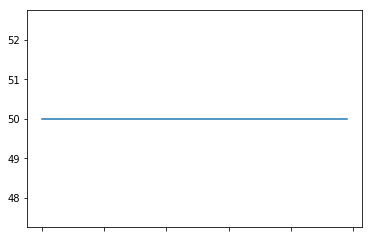

In [11]:
df_train['author'].value_counts().plot()

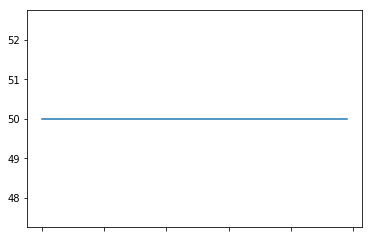

In [13]:
df_test['author'].value_counts().plot()

Train and test data are similarly distributed. An article can be attributed to an author based on the topic and content of the article or the author writing style or mix of both. In my basic approach, I will try to solve the problem by leveraging the frequency of words in the article, which represents the topic of an article. For this, I will construct a TF-IDF matrix. I am not going to rely on the default tokenizer provided by the scikit learn; I will create one for myself. The custom tokenizer involved three steps:

* Tokenize the article into sentences and sentences into words
* Filter the tokens with smaller lengths (assuming smaller words doesn't really say anything about the topic), whether a word is stop word or not, and whether the word is present in the dictionary or not
* Stem the words 

I am also going to construct a raw counts matrix as some models like MultinomialNB often perform better on raw counts

In [17]:
def tokenize_and_stem(text):
    """
    Below function tokenizes and lemmatizes the texts. It also does some cleaning by removing non dictionary words
    This can be used to replace default tokenizer provided by feature extraction api of sklearn.
    :param text: str
    :return: list
    """
    stemmer = SnowballStemmer("english")
    stop_words = stopwords.words("english")
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []

    for token in tokens:

        if re.search(r'[a-zA-Z-]{4,}', token) and token not in stop_words and len(wn.synsets(token)) > 0:
            token.strip()
            filtered_tokens.append(token)
    filtered_tokens = [stemmer.stem(token) for token in filtered_tokens]
    return filtered_tokens

In [18]:
tfidf_vec = TfidfVectorizer(max_df=0.8, max_features=10000,
                            min_df=0.02, use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1, 2))
counter_vect = CountVectorizer(max_df=0.8, max_features=10000,
                               min_df=0.02, tokenizer=tokenize_and_stem, ngram_range=(1, 2))

In [19]:
tfidf_train = tfidf_vec.fit_transform(df_train['articles'])
tfidf_test = tfidf_vec.transform(df_test['articles'])

In [20]:
counter_train = counter_vect.fit_transform(df_train['articles'])
counter_test = counter_vect.transform(df_test['articles'])

In [21]:
le = LabelEncoder()
df_train['target'] = le.fit_transform(df_train['author'])
df_test['target'] = le.transform(df_test['author'])

Now I have the features and target ready, I will start building the models. I will first start with Bernoulli Naive Bayes, which is simple and fast yet powerful. 

<h3 style="color:orange;"><b><i>Naive Bayes for Classification</i></b></h3>

In [22]:
X_train, X_test,y_train,y_test = tfidf_train, tfidf_test, df_train['target'], df_test['target']

In [23]:
clf_nb = BernoulliNB()
clf_nb.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [25]:
print("Train score of Naive Bayes Classifer is {}".format(clf_nb.score(X_train,y_train)))
print("Test score of Naive Bayes Classifer is {}".format(clf_nb.score(X_test,y_test)))

Train score of Naive Bayes Classifer is 0.9524
Test score of Naive Bayes Classifer is 0.6432


This is a decent baseline considering the fact that data is small with many classes to classify. I will try MultinomialNB which often performs better, as it leverages the numerical properties of the data.

In [27]:
clf_mnb = MultinomialNB()

clf_mnb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [28]:
print("Train score of Multinominal Naive Bayes Classifer is {}".format(clf_mnb.score(X_train,y_train)))
print("Test score of Multinominal Naive Bayes Classifer is {}".format(clf_mnb.score(X_test,y_test)))

Train score of Multinominal Naive Bayes Classifer is 0.8748
Test score of Multinominal Naive Bayes Classifer is 0.5996


MultinomialNB() doesn't often work well on TF-IDF matrix. Hence, I will try raw counts matrix with MultinomialNB

In [30]:
X_train_counts, X_test_counts = counter_train, counter_test
y_train_counts, y_test_counts = df_train['target'], df_test['target']

In [31]:
clf_mnb = MultinomialNB()
clf_mnb.fit(X_train_counts, y_train_counts)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [32]:
print("Train score of Multinominal Naive Bayes Classifer on Raw counts is {}".format(
    clf_mnb.score(X_train_counts, y_train_counts)))
print("Test score of Multinominal Naive Bayes Classifer on Raw counts is {}".format(
    clf_mnb.score(X_test_counts, y_test_counts)))

Train score of Multinominal Naive Bayes Classifer on Raw counts is 0.9432
Test score of Multinominal Naive Bayes Classifer on Raw counts is 0.6256


Surprisingly, BernoulliNB is still a champ. I will try to do parameter tuning using Gridsearch. However, throughout the notebook, I will not perform extensive parameter tuning due to my system constraints

<h3 style="color:Green;"><b><i>Parameter Tuning using Gridsearch And Pipeline</i></b></h3>

In [34]:
pipe_naive = Pipeline([('tfidf', TfidfVectorizer()),
    ('naive', BernoulliNB())])

In [35]:
pipe_naive.set_params(tfidf__tokenizer=tokenize_and_stem)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...ocabulary=None)), ('naive', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))])

In [37]:
param_grid = {
    'tfidf__min_df': [0.2,0.1, 0.02],
    'tfidf__ngram_range':[(1,1),(1,2),(1,3)]
}

In [38]:
search = GridSearchCV(pipe_naive, param_grid, cv=4,return_train_score=False)
search.fit(df_train['articles'],df_train['target'])

GridSearchCV(cv=4, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...ocabulary=None)), ('naive', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)], 'tfidf__min_df': [0.2, 0.1, 0.02]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring=None, verbose=0)

In [39]:
print("The best score after the Grid Search is {}".format(search.best_score_))

The best score after the Grid Search is 0.6608


The training score actually decreased as doing cross validation decreases the training set size of an already relatively small training set. Nonetheless, I will see if it performs any better on the test set

In [41]:
print("The score of best estimator on the test dataset is {}".format(
    search.best_estimator_.score(df_test['articles'], df_test['target'])))

The score of best estimator on the test dataset is 0.6432


<h3 style="color:Blue;"><b><i>Logistic Regression OVR</i></b></h3>

In [43]:
clf_log = LogisticRegression(C=0.2) #highly regularizing as from the above results models are overfitting
clf_log.fit(X_train, y_train)

LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [44]:
print("Train score of Logistic Regression on Tfidf matrix is {}".format(clf_log.score(X_train,y_train)))
print("Test score of Logistic Regression on Tfidf matrix is {}".format(clf_log.score(X_test,y_test)))

Train score of Logistic Regression on Tfidf matrix is 0.808
Test score of Logistic Regression on Tfidf matrix is 0.5584


<h3 style="color:Red;"><b><i>XGBOOST</i></b></h3>

Tree-based models often don't perform well on the high dimensional data. Therefore, I will try to reduce the dimensions using PCA and see if it helps. My choice of the parameters of XGboost is heavily influenced by the results obtained from the above models. I try to make trees as conservative as possible.

In [104]:
params = {'booster': 'gbtree', 'max_depth': 2, 'objective': 'multi:softmax', 'eta': 0.08, 'gamma': 1.5, 
          'num_class': 50, 'saubsample': 0.7, 'eval_metric': ['merror', 'mlogloss'], 'colsample_bytree': 0.55, 
          'tree_method': 'exact', 'lambda': 2, 'min_child_weight': 3}

In [105]:
train_data = xgb.DMatrix(X_train, y_train)
test_data = xgb.DMatrix(X_test, y_test)
watchlist = [(train_data, 'train_score'), (test_data, 'test_score')]

In [106]:
xgb_early_stop = xgb.callback.early_stop(4) #early stopping if the validation accuracy isn't increasing after 4 rounds

In [107]:
clf_xgb = xgb.train(params, train_data, evals=watchlist, num_boost_round=50, callbacks=[xgb_early_stop])

Multiple eval metrics have been passed: 'test_score-mlogloss' will be used for early stopping.

Will train until test_score-mlogloss hasn't improved in 4 rounds.
[0]	train_score-merror:0.6024	train_score-mlogloss:3.60672	test_score-merror:0.6892	test_score-mlogloss:3.67707
[1]	train_score-merror:0.4784	train_score-mlogloss:3.3457	test_score-merror:0.6488	test_score-mlogloss:3.48757
[2]	train_score-merror:0.3948	train_score-mlogloss:3.10366	test_score-merror:0.5952	test_score-mlogloss:3.30939
[3]	train_score-merror:0.3532	train_score-mlogloss:2.91073	test_score-merror:0.5752	test_score-mlogloss:3.17067
[4]	train_score-merror:0.3144	train_score-mlogloss:2.75082	test_score-merror:0.5592	test_score-mlogloss:3.06465
[5]	train_score-merror:0.2888	train_score-mlogloss:2.60244	test_score-merror:0.5524	test_score-mlogloss:2.9596
[6]	train_score-merror:0.2712	train_score-mlogloss:2.47083	test_score-merror:0.536	test_score-mlogloss:2.86041
[7]	train_score-merror:0.2568	train_score-mlogloss:2.3504

In [108]:
pred_train = clf_xgb.predict(train_data)
pred_test = clf_xgb.predict(test_data)

In [109]:
print("Accuracy of XGboost model on the TF-IDF train matrix is {}".format(metrics.accuracy_score(pred_train, 
                                                                                                 y_train)))
print("Accuracy of XGboost model on the TF-IDF test matrix is {}".format(metrics.accuracy_score(pred_test, 
                                                                                                y_test)))

Accuracy of XGboost model on the TF-IDF train matrix is 0.932
Accuracy of XGboost model on the TF-IDF test matrix is 0.5632


In [126]:
top_features = [int(i[1:]) for i, j in sorted(clf_xgb.get_fscore().items(), key=lambda x: x[1])[::-1][:150]]

BernoulliNB() still remains the best model. Ofcourse, one can do lot of parameter tuning with Xgboost. 

<h3 style="color:Orange;"><b><i>Dimensionality Reduction</i></b></h3>

As stated above, tree based models tends to perform well with less number of dimensions. Hence, using PCA to see if it helps any way.

In [57]:
pca = PCA(n_components=500)  # selecting only top 500 principal components
X_train_pca = pca.fit_transform(tfidf_train.toarray())
X_test_pca = pca.transform(tfidf_test.toarray())

In [58]:
train_data = xgb.DMatrix(X_train_pca, y_train)
test_data = xgb.DMatrix(X_test_pca, y_test)
watchlist = [(train_data, 'train_score'), (test_data, 'test_score')]

In [59]:
params = {'booster': 'gbtree', 'max_depth': 3, 'objective': 'multi:softmax', 'eta': 0.08, 'gamma': 1.5, 
          'num_class': 50, 'saubsample': 0.7, 'eval_metric': ['merror', 'mlogloss'], 'colsample_bytree': 0.8, 
          'tree_method': 'exact', 'lambda': 2, 'min_child_weight': 3}

In [60]:
clf_xgb = xgb.train(params, train_data, evals=watchlist, num_boost_round=40, callbacks=[xgb_early_stop])

[0]	train_score-merror:0.5812	train_score-mlogloss:3.61727	test_score-merror:0.724	test_score-mlogloss:3.72148
[1]	train_score-merror:0.4312	train_score-mlogloss:3.36396	test_score-merror:0.6632	test_score-mlogloss:3.57029
[2]	train_score-merror:0.3716	train_score-mlogloss:3.13274	test_score-merror:0.6472	test_score-mlogloss:3.445
[3]	train_score-merror:0.3244	train_score-mlogloss:2.91892	test_score-merror:0.6272	test_score-mlogloss:3.32938
[4]	train_score-merror:0.2816	train_score-mlogloss:2.72845	test_score-merror:0.6176	test_score-mlogloss:3.22214
[5]	train_score-merror:0.2444	train_score-mlogloss:2.56635	test_score-merror:0.6076	test_score-mlogloss:3.13425
[6]	train_score-merror:0.2172	train_score-mlogloss:2.42279	test_score-merror:0.6028	test_score-mlogloss:3.05821
[7]	train_score-merror:0.1976	train_score-mlogloss:2.29031	test_score-merror:0.5952	test_score-mlogloss:2.98636
[8]	train_score-merror:0.1876	train_score-mlogloss:2.1694	test_score-merror:0.582	test_score-mlogloss:2.914

In [61]:
pred_train = clf_xgb.predict(train_data)
pred_test = clf_xgb.predict(test_data)

In [62]:
print("Accuracy of XGboost model on the  reduced TF-IDF train matrix is {}".format(
    metrics.accuracy_score(pred_train, y_train)))
print("Accuracy of XGboost model on the reduced TF-IDF test matrix is {}".format(
    metrics.accuracy_score(pred_test, y_test)))

Accuracy of XGboost model on the  reduced TF-IDF train matrix is 0.9704
Accuracy of XGboost model on the reduced TF-IDF test matrix is 0.4944


<h3 style="color:Violet;"><b><i>Deep Learning</i></b></h3>

While above models tried to use the classify the articles based on the words and their frequencies, I will try to build a sequence model that tries to capture the writing style of an author. However, I am dubious about the effectiveness of these models considering the limited amount of data.

I will change the tokenizer by removing stem as I am going to replace words with Glove embeddings that provide relevant words vectors to all verb forms of a word. Below are the changes that I will make:

* Remove words in the quotes as they don't contribute to capture the writing style of the author.
* Not stemming the words to replace the words with corresponsing Glove vectors
* Not removing stop words, as some authors whose articles aren't published online may not hesitate to use lot of stop words 

In [66]:
def tokenize_and_join(text):
    stop_words = stopwords.words("english")
    text = re.sub('"([^"]*)"', '', text)
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if len(wn.synsets(token)) > 0:
            token.strip()
            filtered_tokens.append(token)
    return ' '.join(filtered_tokens)

In [67]:
df_train['articles_filtered'] = df_train['articles'].apply(tokenize_and_join)
df_test['articles_filtered'] = df_test['articles'].apply(tokenize_and_join)

In [69]:
max_features = 10000
max_length = 250

In [70]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(df_train['articles_filtered']) + list(df_test['articles_filtered']))
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(df_train['articles_filtered']), maxlen=max_length)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(df_test['articles_filtered']), maxlen=max_length)

In [71]:
y_train_seq = to_categorical(df_train['target'])
y_test_seq = to_categorical(df_test['target'])

In [72]:
# Using 50 dimensional Glove vectors
file = open('/Users/ajit_samudrala/author_attribution/glove50d.txt', encoding="utf8")  
embeddings_index={}
for line in file:
    values = line.split()
    word = values[0]
    embeddings = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = embeddings
file.close()

In [73]:
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_features, 50), dtype='float32')

In [74]:
for word, i in word_index.items(): 
    if i < max_features:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:  
            embedding_matrix[i-1] = embedding_vector

In [83]:
model = Sequential()
model.add(Embedding(max_features, 50))
model.add(Conv1D(32, 5, activation='relu'))
model.add(SpatialDropout1D(0.1))
model.add(Conv1D(32, 5, activation='relu'))
model.add(SpatialDropout1D(0.1))
model.add(Bidirectional(LSTM(32, dropout=0.1, recurrent_dropout=0.1, return_sequences=True)))
model.add(Bidirectional(LSTM(32, dropout=0.1, recurrent_dropout=0.1, return_sequences=True)))
model.add(GlobalAvgPool1D())
model.add(Dense(50, activation='softmax'))

In [84]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 50)          500000    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          8032      
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, None, 32)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, None, 32)          0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, None, 64)          16640     
_________________________________________________________________
bidirectional_6 (Bidirection (None, None, 64)          24832     
__________

In [85]:
model.layers[0].set_weights([embedding_matrix]) # replacing weights matrix with Glove embeddings

model.layers[0].trainable = False # As the training set is small, I will not be training word embeddings

In [86]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train_seq, y_train_seq, epochs=30, batch_size=512, validation_data=(X_test_seq, y_test_seq))

Train on 2500 samples, validate on 2500 samples
Epoch 1/30
2500/2500 [==============================] - 29s 12ms/step - loss: 3.9151 - acc: 0.0188 - val_loss: 3.9109 - val_acc: 0.0200
Epoch 2/30
2500/2500 [==============================] - 28s 11ms/step - loss: 3.9128 - acc: 0.0124 - val_loss: 3.9088 - val_acc: 0.0256
Epoch 3/30
2500/2500 [==============================] - 30s 12ms/step - loss: 3.9088 - acc: 0.0260 - val_loss: 3.9060 - val_acc: 0.0348
Epoch 4/30
2500/2500 [==============================] - 31s 13ms/step - loss: 3.9067 - acc: 0.0228 - val_loss: 3.9027 - val_acc: 0.0384
Epoch 5/30
2500/2500 [==============================] - 31s 12ms/step - loss: 3.9015 - acc: 0.0328 - val_loss: 3.8972 - val_acc: 0.0368
Epoch 6/30
2500/2500 [==============================] - 31s 13ms/step - loss: 3.8964 - acc: 0.0380 - val_loss: 3.8908 - val_acc: 0.0368
Epoch 7/30
2500/2500 [==============================] - 33s 13ms/step - loss: 3.8895 - acc: 0.0380 - val_loss: 3.8833 - val_acc: 0.0372


As expected accuracy is really bad. Nonetheless, I will try if the network has learned any high level features that may actually improve the accuracy of the earlier model

In [87]:
inp = model.input
# capturing the final avg pool layer activations to see if they have captured any imp features
out = model.layers[7].output 
func = K.function([inp, K.learning_phase()], [out])

<h4 style="color:blue;">Combining top features obtained from the previous model with the features learned from the network. I am combining with only top features so that model will be forced to chose the add on features learned from netowrk</h4>

In [129]:
X_train_combined = np.concatenate([func([X_train_seq, 0])[0], X_train.toarray()[:, top_features]], axis=1)
X_test_combined = np.concatenate([func([X_test_seq, 1])[0], X_test.toarray()[:, top_features]], axis=1)

In [130]:
print("shape of the original TF-IDF Matrix is {}".format(X_train.shape))
print("shape of the TF-IDF matrix combined with features from neural network is {}".format(X_train_combined.shape))

shape of the original TF-IDF Matrix is (2500, 1787)
shape of the TF-IDF matrix combined with features from neural network is (2500, 214)


<h3 style="color:Red;"><b><i>Combined Matrix XGBOOST model</i></b></h3>

In [131]:
train_data = xgb.DMatrix(X_train_combined, y_train)
test_data = xgb.DMatrix(X_test_combined, y_test)
watchlist = [(train_data, 'train_score'), (test_data, 'test_score')]

In [136]:
params = {'booster': 'gbtree', 'max_depth': 2, 'objective': 'multi:softmax', 'eta': 0.08, 'gamma': 1.5, 
          'num_class': 50, 'saubsample': 0.7, 'eval_metric': ['merror', 'mlogloss'], 'colsample_bytree': 0.7, 'tree_method': 'exact',
          'lambda': 2, 'min_child_weight': 3}

In [137]:
clf_xgb_comb = xgb.train(params, train_data, evals=watchlist, num_boost_round=60, callbacks=[xgb_early_stop])

[0]	train_score-merror:0.5664	train_score-mlogloss:3.58805	test_score-merror:0.6612	test_score-mlogloss:3.6415
[1]	train_score-merror:0.464	train_score-mlogloss:3.32186	test_score-merror:0.6276	test_score-mlogloss:3.45052
[2]	train_score-merror:0.4112	train_score-mlogloss:3.08747	test_score-merror:0.594	test_score-mlogloss:3.27983
[3]	train_score-merror:0.3672	train_score-mlogloss:2.89336	test_score-merror:0.5712	test_score-mlogloss:3.14208
[4]	train_score-merror:0.3356	train_score-mlogloss:2.72798	test_score-merror:0.5556	test_score-mlogloss:3.02756
[5]	train_score-merror:0.3176	train_score-mlogloss:2.58258	test_score-merror:0.5476	test_score-mlogloss:2.92
[6]	train_score-merror:0.3032	train_score-mlogloss:2.45304	test_score-merror:0.5416	test_score-mlogloss:2.82772
[7]	train_score-merror:0.292	train_score-mlogloss:2.3454	test_score-merror:0.5344	test_score-mlogloss:2.74996
[8]	train_score-merror:0.2808	train_score-mlogloss:2.24306	test_score-merror:0.5288	test_score-mlogloss:2.67947


In [138]:
pred_train = clf_xgb_comb.predict(train_data)
pred_test = clf_xgb_comb.predict(test_data)

In [139]:
print("Accuracy of XGboost model on the TF-IDF train matrix combined with features from neural netowrk is {}".format(
    metrics.accuracy_score(pred_train, y_train)))
print("Accuracy of XGboost model on the TF-IDF test matrix combined with features from neural netowrk is {}".format(
    metrics.accuracy_score(pred_test, y_test)))

Accuracy of XGboost model on the TF-IDF train matrix combined with features from neural netowrk is 0.88
Accuracy of XGboost model on the TF-IDF test matrix combined with features from neural netowrk is 0.524


Even this strategy didn't work out and still BernoulliNB tops the accuracy

<h3 style="color:Red;"><b><i>Manual Error Analysis</i></b></h3>

Since the best performing model is BernoulliNB , I will do error analysis on it

In [140]:
pred_test = clf_nb.predict(X_test)
mis_cls_samples = np.where(pred_test != y_test)[0]
report = metrics.classification_report(y_pred=pred_test, y_true=y_test)

In [196]:
def report_to_df(report):
    report = re.sub(r" +", " ", report).replace("avg / total", "avg/total").replace("\n ", "\n")
    report_df = pd.read_csv(StringIO("Classes" + report), sep=' ', index_col=0)
    return (report_df)

In [197]:
result_df = report_to_df(report)

In [198]:
bad_recall_scores = result_df.loc[result_df['recall']<0.5,:].sort_values('recall')

In [199]:
bad_recall_scores

,precision,recall,f1-score,support
Classes,,,,
7,0.39,0.14,0.21,50
6,0.86,0.24,0.38,50
14,0.36,0.26,0.30,50
34,0.54,0.26,0.35,50
12,0.31,0.34,0.33,50
18,0.53,0.40,0.45,50
8,0.62,0.42,0.50,50
31,1.00,0.42,0.59,50
43,0.29,0.42,0.34,50


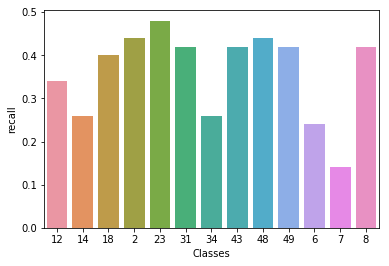

In [200]:
sns.barplot(x=bad_recall_scores.index, y=bad_recall_scores['recall'])

From the above table class 7 is the most misclassified class. I will try to see what are its predictions

In [201]:
np.unique(pred_test[7 * 50 - 1: 7 * 50 + 49], return_counts=True)

(array([ 5,  7, 12, 20, 22, 36, 39, 48], dtype=int64),
 array([ 6,  7,  1,  2,  6,  2,  2, 24], dtype=int64))

Class 7 is often mislabeled as class 48. We can furthur investigate to se why these are being mislabeled

<h3 style="color:Red;"><b><i>Future Work</i></b></h3>

* Perform extensive parameter tuning starting from the choice of whether using stemming or lemmatization to parameters of the model.
* Try different neural network architectures to better capture author writing style. For example, article level based architecture instead of sentence-level architecture
* Try using POS tagging to see if any author tend to use certain POS more in their articles
* If possible gain more data or allocate more data to the training data to get a better representation of test data